In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image

%matplotlib inline

# Loading Data

In [2]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')

In [3]:
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

# Visualize Data

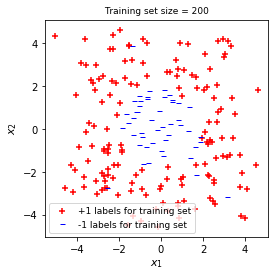

In [4]:
#Select positive target and negative target
positive_index = np.where(y_train>0)[0]
x_positive = x_train[positive_index]

negative_index = np.where(y_train<=0)[0]
x_negative = x_train[negative_index]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (x_positive[:,0], x_positive[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (x_negative[:,0], x_negative[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [5]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Classifier

In [6]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    entropy = 0.
    for prob in prob_list:
        if prob == 0.:
            pass
        else:
            entropy += -1. * prob * np.log(prob)
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    gini = 0.
    for prob in prob_list:
        gini += prob * (1 - prob)
    return gini

# criterion dictionary containing two different splitting methods for decision tree classifier
criterion_dict = {'gini': compute_gini, 'entropy': compute_entropy}

In [7]:
class DTree_classifier:
    '''
    Decision classifier class
    
    :attribute train: a numpy array of training data in this node
    :attribute criterion: methods for splitting this node
    :attribute label: label predicted by this node
    :attribute is_leaf(boolen): indicator of leaf node
    :attribute split_id: feature used for splitting this node
    :attribute split_value: value used for splitting this node
    :attribute left: DTree_classifier object
    :attribute right: DTree_classifier object
    '''
    def __init__(self, train_data, train_label, depth=0, criterion='entropy', min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier
        
        :param train_data: a numpy array of training data, shape = (n, m)
        :param train_label: a numpy array of labels, shape = (n, 1)
        :param depth: depth indicator, default value is 0, representing root node
        :param criterion: methods for splitting node, default method is entropy
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.train = train_data
        self.criterion = criterion
        
        label_cnt = Counter(train_label.reshape(len(train_label)))
        self.label = label_cnt.most_common(1)[0][0]
        
        if len(train_data) < min_sample or depth > max_depth:
            self.is_leaf = True
            return

        # split this node
        self.split_id, self.split_value = self.split_tree(train_data, train_label)

        if self.split_id == -1:
            self.is_leaf = True
            return

        # create subtree on left and right
        self.is_leaf = False
        left_index = np.where(train_data[:, self.split_id] <= self.split_value)
        right_index = np.where(train_data[:, self.split_id] > self.split_value)
        
        self.left = DTree_classifier(train_data[left_index], train_label[left_index], depth+1, criterion=criterion,\
                          max_depth=max_depth)
        self.right = DTree_classifier(train_data[right_index], train_label[right_index], depth+1, criterion=criterion,\
                           max_depth=max_depth)

    def split_tree(self, train_data, train_label):
        '''
        Split the internal node of decision tree
        
        :param train_data: a numpy array of training data, shape = (n, m)
        :param train_label: a numpy array of labels, shape = (n, 1)
        
        :return split_id: feature used for splitting this node, -1 if splitting cannot decrease entropy
        :return split_value: value used for splitting this node, np.inf if splitting cannot decrease entropy
        '''
        split_id = -1
        split_value = np.inf
        min_entropy = criterion_dict[self.criterion](train_label)
        
        for attr_id in range(train_data.shape[1]):
            attr_value = sorted(list(set(train_data[:, attr_id])))
            for i in range(len(attr_value) - 1):
                v = (attr_value[i] + attr_value[i + 1]) / 2.
                
                left_index_temp = np.where(train_data[:, attr_id] <= v)[0]
                right_index_temp = np.where(train_data[:, attr_id] > v)[0]
                
                left_entropy = criterion_dict[self.criterion](train_label[left_index_temp])
                right_entropy = criterion_dict[self.criterion](train_label[right_index_temp])
                
                entropy_ave = (len(left_index_temp) * left_entropy + len(right_index_temp) * right_entropy) / \
                float(len(train_label))
                
                if entropy_ave < min_entropy: # if entropy decreases, update split_id and split_value 
                    split_id = attr_id
                    split_value = v
                    min_entropy = entropy_ave

        return split_id, split_value

    def predict(self, instance):
        '''
        Predict label by decision tree
        
        :param instance: a numpy array with new data, shape (1, m)
        
        :return self.label: predicted label
        '''
        if self.is_leaf:
            return self.label
        if instance[self.split_id] <= self.split_value:
            return self.left.predict(instance)
        else:
            return self.right.predict(instance)

# Decision Tree Boundary

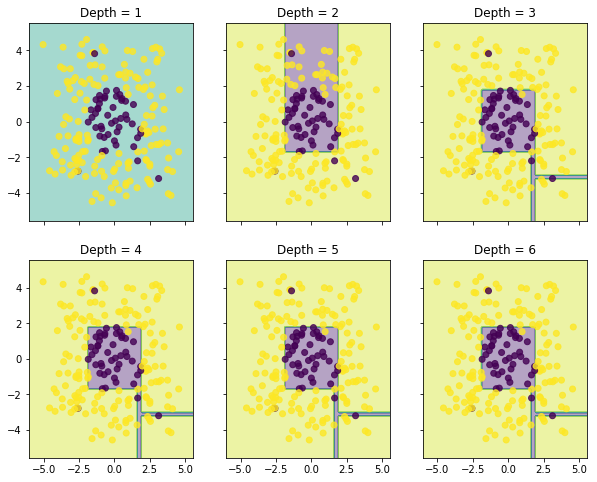

In [8]:
# Loading some example data

# Training classifiers with different depth
clf1 = DTree_classifier(x_train, y_train_label, criterion='entropy', max_depth=1)
clf2 = DTree_classifier(x_train, y_train_label, criterion='entropy', max_depth=2)
clf3 = DTree_classifier(x_train, y_train_label, criterion='entropy', max_depth=3)
clf4 = DTree_classifier(x_train, y_train_label, criterion='entropy', max_depth=4)
clf5 = DTree_classifier(x_train, y_train_label, criterion='entropy', max_depth=5)
clf6 = DTree_classifier(x_train, y_train_label, criterion='entropy', max_depth=6)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [9]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [10]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

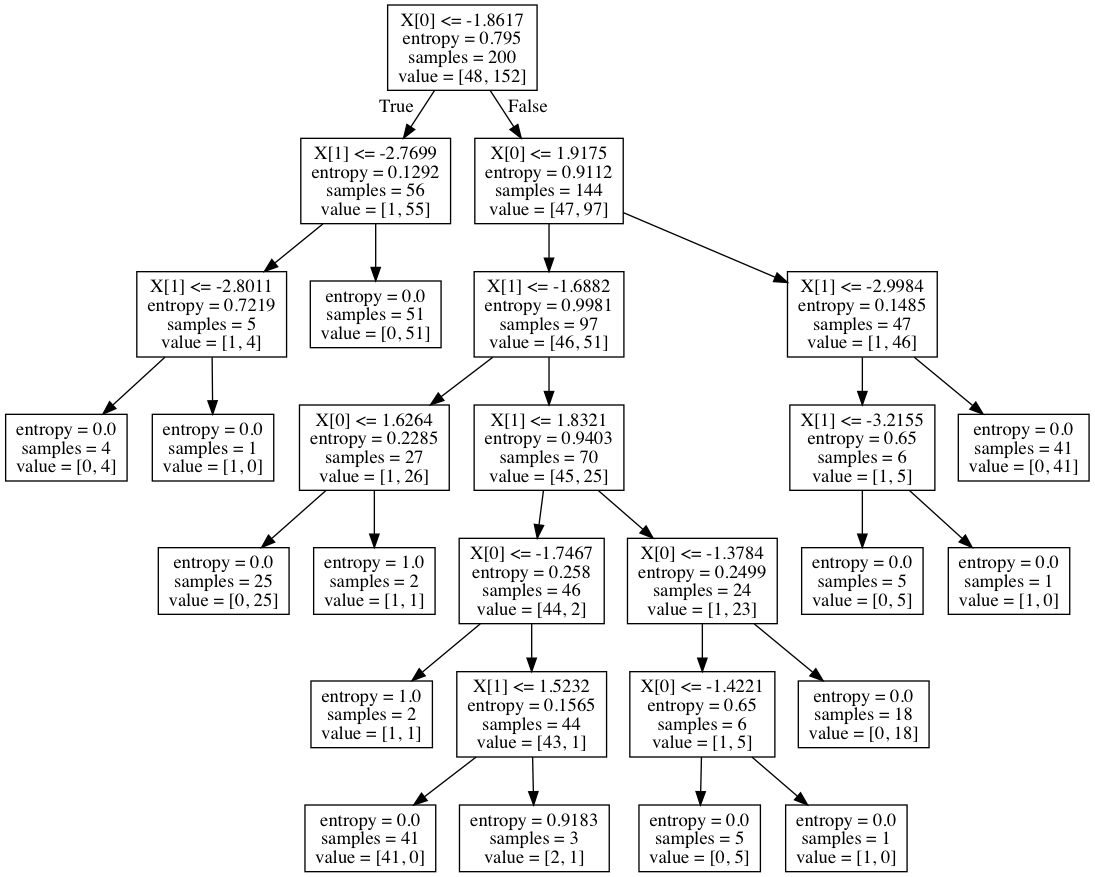

In [11]:
Image(filename='tree_classifier.png')

In [12]:
# compare first splitting point
print('Split_id of root node: {}'.format(clf1.split_id))
print('Split_value of root node: {}'.format(clf1.split_value))
print('Left child size: {}'.format(clf1.left.train.shape[0]))
print('Right child size: {}'.format(clf1.right.train.shape[0]))

Split_id of root node: 0
Split_value of root node: -1.8616606665
Left child size: 56
Right child size: 144


The above result shows that our model is consitent with decision tree model from sklearn.

# Decision Tree Regressor

In [13]:
def compute_loss(target_array):
    '''
    Calulate the square loss of given target list
    
    :param target_array: a numpy array of targets shape = (n, 1)
    :return square_loss
    '''
    mean_value = target_array.mean()
    square_loss = sum((target_array - mean_value)**2)[0]
    return square_loss

In [14]:
class Dtree_regressor:
    '''
    Decision regressor class
    
    :attribute train: a numpy array of training data in this node
    :attribute value: value predicted by this node
    :attribute is_leaf(boolen): indicator of leaf node
    :attribute split_id: feature used for splitting this node
    :attribute split_value: value used for splitting this node
    :attribute left: DTree_regressor object
    :attribute right: DTree_regressor object
    '''
    def __init__(self, train_data, train_target, depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree regressor
        
        :param train_data: a numpy array of training data, shape = (n, m)
        :param train_target: a numpy array of targets, shape = (n, 1)
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.train = train_data
        self.value = train_target.mean()
        
        if len(train_data) < min_sample or depth > max_depth:
            self.is_leaf = True
            return

        # split this node
        self.split_id, self.split_value = self.split_tree(train_data, train_target)

        if self.split_id == -1:
            self.is_leaf = True
            return

        # create subtree on left and right
        self.is_leaf = False
        left_index = np.where(train_data[:, self.split_id] <= self.split_value)
        right_index = np.where(train_data[:, self.split_id] > self.split_value)
        
        self.left = Dtree_regressor(train_data[left_index], train_target[left_index], depth+1, max_depth=max_depth)
        self.right = Dtree_regressor(train_data[right_index], train_target[right_index], depth+1, max_depth=max_depth)

    def split_tree(self, train_data, train_target):
        '''
        Split the internal node of decision tree
        
        :param train_data: a numpy array of training data, shape = (n, m)
        :param train_target: a numpy array of targets, shape = (n, 1)
        
        :return split_id: feature used for splitting this node, -1 if splitting cannot decrease loss
        :return split_value: value used for splitting this node, np.inf if splitting cannot decrease loss
        '''
        split_id = -1
        split_value = np.inf
        min_loss = compute_loss(train_target)
        
        for attr_id in range(train_data.shape[1]):
            attr_value = sorted(list(set(train_data[:, attr_id])))
            for i in range(len(attr_value) - 1):
                v = (attr_value[i] + attr_value[i + 1]) / 2.
                left_index_temp = np.where(train_data[:, attr_id] <= v)[0]
                right_index_temp = np.where(train_data[:, attr_id] > v)[0]
                left_loss = compute_loss(train_target[left_index_temp])
                right_loss = compute_loss(train_target[right_index_temp])
                total_loss = left_loss + right_loss
                if total_loss < min_loss:
                    split_id = attr_id
                    split_value = v
                    min_loss = total_loss

        return split_id, split_value

    def predict(self, instance):
        '''
        Predict value by decision tree
        
        :param instance: a numpy array with new data, shape (1, m)
        
        :return self.value: predicted value
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict(instance)
        else:
            return self.right.predict(instance)

In [15]:
# Build decision tree regressor
tree_reg = Dtree_regressor(x_train, y_train)

# Compare decision tree with tree model in sklearn

In [16]:
treg_sk = DecisionTreeRegressor(max_depth=3, min_samples_split=5)
treg_sk.fit(x_train, y_train)
export_graphviz(treg_sk, out_file='tree_regressor.dot')

In [17]:
!dot -Tpng tree_regressor.dot -o tree_regressor.png

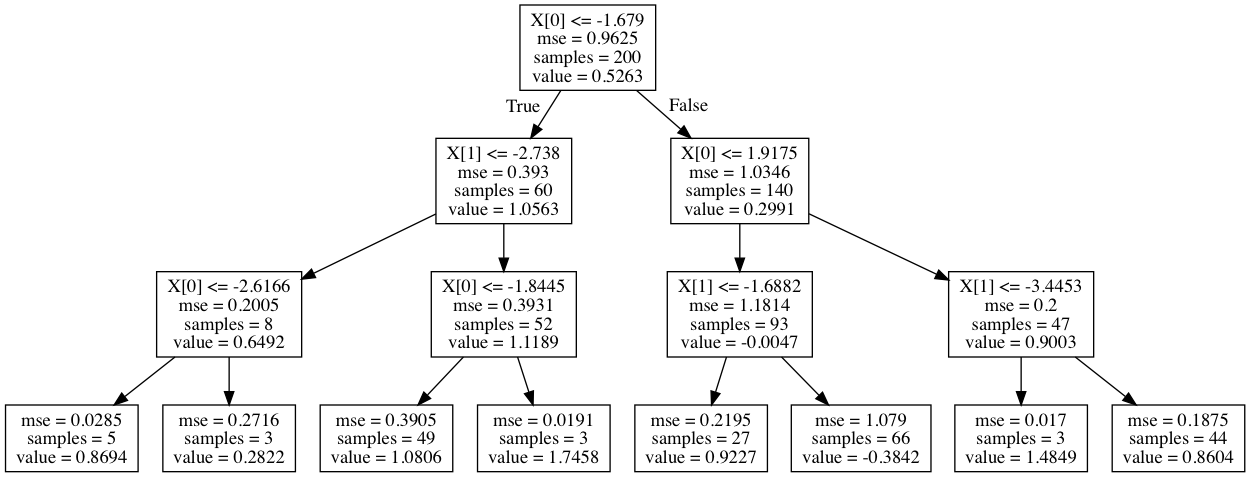

In [18]:
Image(filename='tree_regressor.png')

In [19]:
# compare first splitting point
print('Split_id of root node: {}'.format(tree_reg.split_id))
print('Split_value of root node: {}'.format(tree_reg.split_value))
print('Left child size: {}'.format(tree_reg.left.train.shape[0]))
print('Right child size: {}'.format(tree_reg.right.train.shape[0]))

Split_id of root node: 0
Split_value of root node: -1.67902733099
Left child size: 60
Right child size: 140


The above result shows that our model is consitent with decision tree model from sklearn